In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
import cv2
from google.colab.patches import cv2_imshow
import zipfile
import random

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.6 MB/s 


In [ ]:
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score, f1_score

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/EE610_Assignment4/EE610_Assignment4.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Source for above code : https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

In [ ]:
# Getting the names of all images and masks in respective list

train_img_name = os.listdir('/tmp/EE610_Assignment4/Train/Tissue-Images')
train_mask_name = os.listdir('/tmp/EE610_Assignment4/Train/Binary-Mask')
test_img_name = os.listdir('/tmp/EE610_Assignment4/Test/Tissue-Images')
test_mask_name = os.listdir('/tmp/EE610_Assignment4/Test/Binary-Mask')

In [ ]:
train_img_name.sort()
train_mask_name.sort()
test_img_name.sort()
test_mask_name.sort()

## Preprocessing

In [ ]:
train_img = []
train_mask = []
test_img = []
test_mask = []

for i in range(len(train_img_name)):
  img = cv2.imread(f'/content/drive/MyDrive/EE610_Assignment4/Train/Tissue-Images/{train_img_name[i]}')
  img = cv2.resize(img, (128, 128))
  img = img/255
  train_img.append(img)

  mask = cv2.imread(f'/content/drive/MyDrive/EE610_Assignment4/Train/Binary-Mask/{train_mask_name[i]}')
  mask = cv2.resize(mask, (128, 128))
  mask = mask/255
  train_mask.append(mask)

for i in range(len(test_img_name)):
  img = cv2.imread(f'/content/drive/MyDrive/EE610_Assignment4/Test/Tissue-Images/{test_img_name[i]}')
  img = cv2.resize(img, (128, 128))
  img = img/255
  test_img.append(img)

  mask = cv2.imread(f'/content/drive/MyDrive/EE610_Assignment4/Test/Binary-Mask/{test_mask_name[i]}')
  mask = cv2.resize(mask, (128, 128))
  mask = mask/255
  test_mask.append(mask)

In [ ]:
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size=0.25)

In [ ]:
print(f"Length of Training Dataset : {len(train_img)}")
print(f"Length of Validation Dataset : {len(val_img)}")

Length of Training Dataset : 33
Length of Validation Dataset : 11


In [ ]:
# Converting numpy array to tensor

train_img = tf.convert_to_tensor(train_img)
val_img = tf.convert_to_tensor(val_img)
test_img = tf.convert_to_tensor(test_img)
train_mask = tf.convert_to_tensor(train_mask)
val_mask = tf.convert_to_tensor(val_mask)
test_mask = tf.convert_to_tensor(test_mask)

In [ ]:
# Converting RGB images to Gray Scale

train_mask = tf.image.rgb_to_grayscale(train_mask)
val_mask = tf.image.rgb_to_grayscale(val_mask)
test_mask = tf.image.rgb_to_grayscale(test_mask)

In [ ]:
print(f'Shape of Training Dataset : {train_mask.shape}')
print(f'Shape of Validation Dataset : {val_mask.shape}')
print(f'Shape of Testing Dataset : {test_mask.shape}')

Shape of Training Dataset : (33, 128, 128, 1)
Shape of Validation Dataset : (11, 128, 128, 1)
Shape of Testing Dataset : (14, 128, 128, 1)


In [ ]:
def display_train_img(num):
  print(f"Train Image No. {num}")
  cv2_imshow(train_img[num].numpy()*255)
  print(f"Train Mask No. {num}")
  cv2_imshow(train_mask[num].numpy()*255)

def display_test_img(num):
  print(f"Test Image No. {num}")
  cv2_imshow(test_img[num].numpy()*255)
  print(f"Test Mask No. {num}")
  cv2_imshow(test_mask[num].numpy()*255)

Train Image No. 26


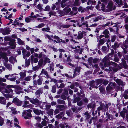

Train Mask No. 26


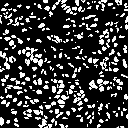

In [ ]:
display_train_img(26)

Test Image No. 9


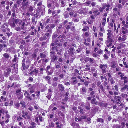

Test Mask No. 9


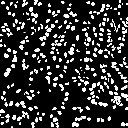

In [ ]:
display_test_img(9)

## UNet Model from Scratch

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(x)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(c)
  c = BatchNormalization()(c)
  p = MaxPool2D((2, 2), (2, 2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding='same', strides=1):
  us = UpSampling2D((2, 2))(x)
  concat = Concatenate()([us, skip])
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(concat)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(c)
  c = BatchNormalization()(c)
  return c

def bottleneck(x, filters, kernel_size=(3, 3), padding='same', strides=1):
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(x)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu', kernel_initializer='he_normal')(c)
  c = BatchNormalization()(c)
  return c

In [ ]:
def UNet(image_size=(128, 128, 3)):
  f = [16, 32, 64, 128, 256, 512]
  inputs = Input(image_size)
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])
  c5, p5 = down_block(p4, f[4])

  bn = bottleneck(p5, f[5])

  u1 = up_block(bn, c5, f[4])
  u2 = up_block(u1, c4, f[3])
  u3 = up_block(u2, c3, f[2])
  u4 = up_block(u3, c2, f[1])
  u5 = up_block(u4, c1, f[0])

  outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u5)
  model = Model(inputs, outputs)
  return model

In [ ]:
model = UNet(image_size=(128, 128, 3))

In [ ]:
opt = SGD(learning_rate = 0.01)
model.compile(optimizer = opt, loss = dice_loss, metrics = [f1_score])

In [ ]:
history = model.fit(x=train_img, y=train_mask, batch_size=11, epochs=10, validation_data=(val_img, val_mask), verbose=1)

Epoch 1/10
3/3 [==============================] - 19s 6s/step - loss: 0.6778 - f1-score: 0.3222 - val_loss: 0.6991 - val_f1-score: 0.3009
Epoch 2/10
3/3 [==============================] - 15s 5s/step - loss: 0.6729 - f1-score: 0.3271 - val_loss: 0.7014 - val_f1-score: 0.2986
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 0.6679 - f1-score: 0.3321 - val_loss: 0.7034 - val_f1-score: 0.2966
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 0.6623 - f1-score: 0.3377 - val_loss: 0.7050 - val_f1-score: 0.2950
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 0.6579 - f1-score: 0.3421 - val_loss: 0.7060 - val_f1-score: 0.2940
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 0.6520 - f1-score: 0.3480 - val_loss: 0.7069 - val_f1-score: 0.2931
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 0.6466 - f1-score: 0.3534 - val_loss: 0.7081 - val_f1-score: 0.2919
Epoch 8/10
3/3 [=======================

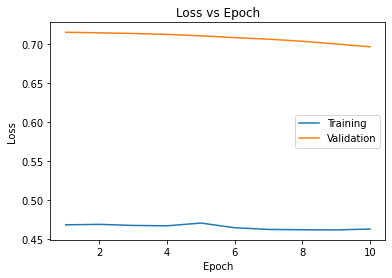

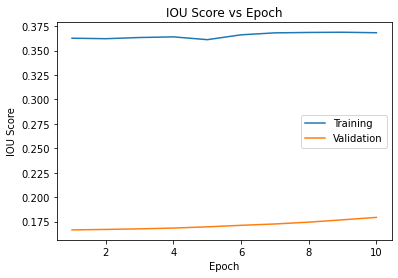

In [ ]:
x = np.arange(1, 11)
plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

plt.plot(x, history.history['f1_score'])
plt.plot(x, history.history['val_f1_score'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epoch')
plt.show()

In [ ]:
pred_train = model.predict(test_img)
pred_values = pred_train.copy()

# Converting output probability map to binary map

pred_values[pred_train>0.35]=1
pred_values[pred_train<0.35]=0

1/1 [==============================] - 1s 810ms/step


In [ ]:
# Finding the optimum threshold

for i in np.arange(0.26, 0.35, 0.01):
  pred_values[pred_train>i]=1
  pred_values[pred_train<i]=0
  print(f'F1 Score on test data if threshold = {(i*100//1)/100} : {f1_score(test_mask, pred_values)}')

IOU Score on test data if threshold = 0.26 : 0.36447397974978557
IOU Score on test data if threshold = 0.27 : 0.3697773884320793
IOU Score on test data if threshold = 0.28 : 0.373777377000755
IOU Score on test data if threshold = 0.29 : 0.3777924694188252
IOU Score on test data if threshold = 0.3 : 0.3797519446149551
IOU Score on test data if threshold = 0.31 : 0.38143554326347856
IOU Score on test data if threshold = 0.32 : 0.38140244520900823
IOU Score on test data if threshold = 0.33 : 0.37840992158516734
IOU Score on test data if threshold = 0.34 : 0.37378326886184987


In [ ]:
pred_values[pred_train>0.31]=1
pred_values[pred_train<0.31]=0

In [ ]:
print(f'F1 Score on test data : {f1_score(test_mask, pred_values)}')

IOU Score on test data : 0.38143554326347856


1
Test Image


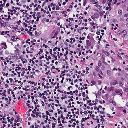

Actual Mask


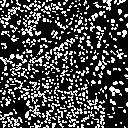

Predicted Mask


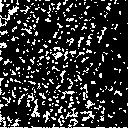

In [ ]:
n = random.randrange(0, 13)
print(n)
print("Test Image")
cv2_imshow(test_img[n].numpy()*255)
print("Actual Mask")
cv2_imshow(test_mask[n].numpy()*255)
print("Predicted Mask")
cv2_imshow(pred_values[n]*255)